# Interactive Bar Plot

---

The chart constructed in this notebook is based on the ideas exposed in the following paper:


&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;Ferreira, N., Fisher, D., & Konig, A. C. (2014, April). [Sample-oriented task-driven visualizations: allowing users to make better, more confident decisions.](https://www.microsoft.com/en-us/research/wp-content/uploads/2016/02/Ferreira_Fisher_Sample_Oriented_Tasks.pdf) 
&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;In Proceedings of the SIGCHI Conference on Human Factors in Computing Systems (pp. 571-580). ACM. ([video](https://www.youtube.com/watch?v=BI7GAs-va-Q))


The authors describe the challenges users face when trying to make judgements about probabilistic data generated through samples They build epresentations that do not answer questions such as "is this bar/value higher than this other bar/value" or "are these bars/values higher or lower than this given value", instead they give answers to questions like "what are the chances this bar/value higher than this other bar/value" or "how likely are these bars/values to be higher or lower than this given value".


I feed the plot with sample data of four different years (which in this example was randomly generate) and the plot inferes the probability distribution for each aggregate by means of the Central Limit Theorem. The inferred population distribution is use in later stages to generate random series of samples (Monte-Carlo approach) and answer the questions mentioned above: 
What are the chances this bar/value higher than this other bar/value? 
How likely are these bars/values to be higher or lower than this given value?


In [1]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
from matplotlib.widgets import RadioButtons
#The chart will be plot inline
%matplotlib notebook
#Let's generate random data for four large samples each of them belonging to a different year (1992,1993,1994,1995)
#np.random.seed(12345)

df = pd.DataFrame([np.random.normal(32000,200000,3650), 
                   np.random.normal(43000,100000,3650), 
                   np.random.normal(43500,140000,3650), 
                   np.random.normal(48000,70000,3650)], 
                  index=[1992,1993,1994,1995])
df

,0,1,2,3,4,5,6,7,8,9,...,3640,3641,3642,3643,3644,3645,3646,3647,3648,3649
1992,214594.357459,289658.040318,-284929.370167,156726.774775,57626.943634,-50963.498101,223558.597089,81256.237550,-9269.519719,-340222.891100,...,378113.049734,360109.540239,-73665.605406,342773.896903,-150308.934601,-149429.779722,6498.842401,-98503.773086,126864.453728,-322079.806056
1993,155486.171766,96620.404326,-153964.404513,171508.488614,-14837.719633,94308.000636,-87970.368405,-37796.787683,140763.858716,132315.101043,...,15804.204692,181785.728176,173252.057167,-73593.676292,164360.949351,140461.942352,31842.421224,-24773.508585,195826.967218,156215.736947
1994,-110164.309869,93196.429514,188148.694118,-81804.071316,-77136.087751,55816.967611,-212.156586,-93947.337602,-79017.259544,114807.984583,...,17154.580150,-62195.259982,-70612.702029,187315.537443,4840.879669,161609.825528,56689.763975,274941.446896,45040.704111,128200.451750
1995,-12445.557493,194125.421224,16269.563558,130487.191224,4858.119701,145539.167827,-7828.020731,-14959.334633,64276.911604,58323.851387,...,29880.288768,31052.296115,59220.646659,131427.659349,33964.518737,16386.639279,-71295.433532,-78657.393770,87243.140289,1014.588198


In [10]:
class on_pick():
    '''On pick event'''
    def __init__(self, means, ax, bar, text_ax, cmap):
        self.my_means = means
        self.my_ax = ax
        self.my_bar = bar
        self.my_text_ax = text_ax
        self.my_cmap = cmap     
    def __call__(self, event):
        '''This method controls the behavior of the class when called'''
        #It text is showing just remove it
        try:
            self.my_text.remove()
        except:
            pass
        #Get the element (artist) pick. Only bars were allowed to be selected (picker=True)
        self.my_element = event.artist
        #Get the index of the selected bar
        my_i = int(self.my_element.get_x() + self.my_element.get_width()/2)
        #Means of the samples for the reference bar
        ref = self.my_means[my_i]
        #Show the height of the bar as reference value
        self.my_text=self.my_text_ax.text(x=0.5, y=0.5, s=str(self.my_bar[my_i].get_height()), horizontalalignment='center', 
                                          verticalalignment='center')
        #Color the bars based on how likely are to be taller or shorter than the reference bar
        for i,bar in enumerate(self.my_bar):
            if i == my_i: #The reference bar is as tall as the reference bar 
                bar.set_facecolor(self.my_cmap(0.5))
                bar.set_alpha(1)
            else: #The other bars' colors are computed now
                #Computes the proportion of samples of the bar i which are greater than the corresponding sampe of the ref. bar
                col = self.my_cmap((self.my_means[i] > ref).mean())
                bar.set_facecolor(col)
                bar.set_alpha(1.0)
        
class on_click():
    '''On click event'''
    def __init__(self, means, ax, bar, text_ax, cmap):
        self.my_means = means
        self.my_ax = ax
        self.my_bar = bar
        self.my_line = self.my_ax.axhline(color='green', linestyle='-')
        self.my_text_ax = text_ax
        self.my_cmap = cmap
    def __call__(self, event):
        '''This method controls the behavior of the class when called'''
        #The click must be inside the bar plot area, otherway it is ignored
        if event.inaxes == self.my_ax:
            #It line or text are showing just remove it
            try:
                self.my_line.remove()
                self.my_text.remove()
            except:
                pass
            # Take the y value of the click, draw a line and show the y-value in the reference value box
            self.y_val = event.ydata
            self.my_text=self.my_text_ax.text(x=0.5, y=0.5, s=str(self.y_val), horizontalalignment='center', verticalalignment='center')
            self.my_line = self.my_ax.axhline(y=self.y_val, color='green', linestyle='-')
            #Color the bars based on how likely are to be taller or shorter than the reference value
            for i,bar in enumerate(self.my_bar):
                #Computes the proportion of samples of the bar i which are greater than the reference value
                col = self.my_cmap((self.my_means[i] > self.y_val).mean())
                bar.set_facecolor(col)
                bar.set_alpha(1.0)

In [11]:
class functionality:
    '''This callable class create the corresponding interactive events based on the labels of a radial menu. '''
    def __init__(self, means, stds, fig, ax, bar, text_ax, cmap):
        self.cid = None
        #self.my_line = None
        self.my_means = means
        self.my_stds = stds
        self.my_fig = fig
        self.my_ax = ax
        self.my_bar = bar
        self.my_text_ax = text_ax
        self.my_camp=cmap
        self.my_on_click=None
        #self.my_line = self.my_ax.axhline(y=0.5, color='green', linestyle='-',lw=5,visible=True)  
    def __call__(self, label):
        '''This method controls the behavior of the instnce once its call'''
        if label=='None':  #No interaction at all
            #Clean the display
            self.clean()
        if label=='Ref. Bar': #It allows for selecting a bar by clicking
            #Clean the display
            self.clean()
            #compute the means
            self.get_means()
            #Create the on pick event and connects it
            my_on_pick = on_pick(self.my_sample_means, self.my_ax, self.my_bar,self.my_text_ax,self.my_camp)
            self.cid = self.my_fig.canvas.mpl_connect('pick_event', my_on_pick) 
        if label=='Ref. Line': #It allows for ploting a line by clicking
            #Clean the display
            self.clean()
            #compute the means
            self.get_means()
            #Create the on click event and connects it
            self.my_on_click = on_click(self.my_sample_means, self.my_ax, self.my_bar, self.my_text_ax,self.my_camp)
            self.cid = self.my_fig.canvas.mpl_connect('button_press_event', self.my_on_click)
    
    def clean(self):
        '''This restores the original color of the bar plot, removes any potential line plot and any potential 
        ref. value in display'''
        #If there a line it will delete it from the plot. If the line has not yet been plot the try except block prvents the 
        #interactive plot from crashing
        try:
            self.my_on_click.my_line.remove()
        except:
            pass
        #Disconnect the current event
        if self.cid:
            self.cid = self.my_fig.canvas.mpl_disconnect(self.cid)
        # Recover the original color for the bars
        for bar in self.my_bar:
            bar.set_facecolor(self.my_camp(0.5))
            bar.set_alpha(1.0)
        # Clear the reference value box and rewrite the title of that box
        self.my_text_ax.clear()
        self.my_text_ax.set_title('Ref. Value',fontsize=8)
            
    def get_means(self):
        '''This method generates a series of samples based on the estimated populations means and stds'''
        #Number of samples use
        number_samples=10000
        self.my_sample_means = np.zeros((len(self.my_means),number_samples)) 
        for i in range(len(self.my_means)):
            self.my_sample_means[i][:]=np.random.normal(loc=self.my_means[i], scale=self.my_stds[i], size=number_samples)
        

In [12]:
class my_chart():
    '''This class creates the components of the graph and plots it once called. It only takes one parameter a DataFrame
    with the data'''
    def __init__(self, data):
        self.__data = data # The data itself
        self.__data_prep() 
        #I chose RedBlue color map. Change it here and it will be passed to all the other classes that uses the color map
        self.__cmap=plt.cm.get_cmap('RdBu_r')  
                
    def __data_prep(self):
        '''This method generates the x-labels of the bar plot and also estimates population's and standard deviation from the
        samples'''
        self.__labels = self.__data.index.tolist()
        self.__means= (self.__data.mean(axis=1)).values
        self.__stds = (self.__data.std(axis=1)/np.sqrt(self.__data.shape[1])).values
        
    def __call__(self):
        '''The class it is callable and calling it will render the chart'''
        self.__gen_fig() #Render the different axes
        self.__draw_bar() #Render the bar plot
        self.__incl_menu() #Bring the interactive menu to live
        self.__color_legend() #Render the colorbar
        plt.tight_layout()
        
    def __gen_fig(self):
        '''Creates the different subplots and renders the color scale'''
        #This controls the size of the whole plot
        self.__my_fig = plt.figure(figsize=(6,5))
        #These axes shows the menu that controls the interactivity of the plot
        self.__my_menu_ax = plt.subplot2grid((100,60),(0,0), colspan=20, rowspan=30)
        self.__my_menu_ax.tick_params(axis='both', which='both', bottom='off', left='off', labelbottom='off', labelleft='off')
        self.__my_menu_ax.set_title('Function',fontsize=8)
        #These axes shows the reference value used to color the bars
        self.__my_text_ax = plt.subplot2grid((100,60),(30,0), colspan=20, rowspan=20)
        self.__my_text_ax.tick_params(axis='both', which='both', bottom='off', left='off', labelbottom='off', labelleft='off')
        self.__my_text_ax.set_title('Ref. Value',fontsize=8)
        #These axes contain the colorbar
        self.__my_bar_ax = plt.subplot2grid((100,60),(50,0), colspan=10, rowspan=50)
        self.__my_bar_ax.set_title('Colorbar',fontsize=8)
        #These axes contain the bar plot itself
        self.__my_plot_ax = plt.subplot2grid((100,60),(0,20), colspan=40, rowspan=100)
        
    def __draw_bar(self):
        '''This methid draws the default bar plot. All bars are colored as cmap(0.5) (white for my cmap choice). picker is set
        to True allowing for the bars to be selected by a mouse click'''
        self.__my_bar = self.__my_plot_ax.bar(x=range(len(self.__labels)),height=self.__means, 
                                              width=0.95, color=self.__cmap(0.5), alpha=1.0, 
                                              edgecolor='black', yerr=1.96*self.__stds, capsize=5, picker=True)
        plt.xticks(range(len(self.__labels)), self.__labels)
        
    def __incl_menu(self):
        '''This method sets the interaction menu. Three options: 
        1)None. No interaction
        2)Ref. Bar. A bar can be selected by clicking on it and the other bars are colored based on how likely are to be 
          higher or lower
        3)Ref. Line. A line is plot in the bar plot area and the bars are colored based on how likely are to be higher or lower
        than the y-value of that line'''
        self.__radio = RadioButtons(self.__my_menu_ax, ('None', 'Ref. Bar', 'Ref. Line'))
        #The functionality class contains the information detailing how to proceed depending on the menu choice
        self.__func = functionality(self.__means, self.__stds, self.__my_fig, self.__my_plot_ax, self.__my_bar, 
                                    self.__my_text_ax, self.__cmap)
        #This line links the functionality with the menu
        self.__radio.on_clicked(self.__func)
        
    def __color_legend(self):
        '''This method plots a color legend. Deep blue colors mean zero chances the bar is larger than the reference bar/value.
        Deep red colors mean total confidence in the bar being larger than the reference bar/value.'''
        norm=mpl.colors.Normalize(vmin=0,vmax=1)
        mpl.colorbar.ColorbarBase(self.__my_bar_ax, cmap=self.__cmap,norm=norm,orientation='vertical', alpha=1.0)
        
    

In [13]:
#Let's create the chart
plot = my_chart(df)

Temptative caption:

FIG Y. Magnitude yearly average values between 1992 and 1995. The error bars represent the 95% confidence interval for each measurement. The plot can be use interactively and the type of interection is control by the function menu. The color scale uses indicated how highly a bar is to be larger (red) or smaller (blue) than the reference bar selected or the reference value marked by the ref. line.

<IPython.core.display.Javascript object>


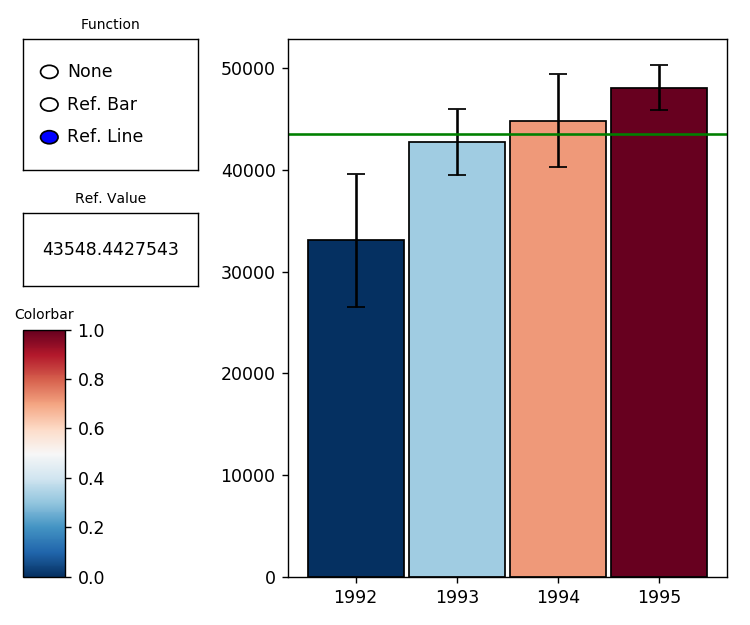

In [14]:
#Let's render the plot
plot()